[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


 10%|█         | 1/10 [00:00<00:03,  2.64it/s]

status: optimal
optimal value 15.71240105955702
optimal var [[-0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     1.    -0.     0.
   0.     0.     0.     0.    -0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.947 -0.     0.
   0.     0.     0.053  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.947 -0.     0.
   0.     0.     0.053  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.947 -0.     0.
   0.     0.     0.053  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.947 -0.     0.
   0.     0.  

 30%|███       | 3/10 [00:00<00:01,  4.26it/s]

status: optimal
optimal value 23.159031638869596
optimal var [[-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.923
   0.     0.     0.077  0.    -0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.923
   0.     0.     0.077  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.923
   0.     0.     0.077  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.923
   0.     0.     0.077  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     0.92

 50%|█████     | 5/10 [00:01<00:01,  5.00it/s]

status: optimal
optimal value 34.69597970712816
optimal var [[-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.917
  -0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.
   0.     0.     0.083  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.917
  -0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.
   0.     0.     0.083  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.917
  -0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.
   0.     0.     0.083  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.917
  -0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.
   0.     0.     0.083  0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.917
  -0.     0.    -0.     0.     0.     0.    -0.     0.    -0.     0.

 60%|██████    | 6/10 [00:01<00:00,  4.54it/s]

status: optimal
optimal value 16.66956853995685
optimal var [[-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.     0.     0.    -0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.     0.     0.    -0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.     0.     0.    -0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.     0.     0.    -0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.  

 70%|███████   | 7/10 [00:01<00:00,  3.63it/s]

status: optimal
optimal value 30.630131922726505
optimal var [[-0.     0.    -0.     0.    -0.     0.    -0.     0.955 -0.     0.
  -0.     0.    -0.     0.     0.045  0.    -0.     0.    -0.     0.
   0.     0.     0.     0.    -0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.955 -0.     0.
  -0.     0.    -0.     0.     0.045  0.    -0.     0.    -0.     0.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.955 -0.     0.
  -0.     0.    -0.     0.     0.045  0.    -0.     0.    -0.     0.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.955 -0.     0.
  -0.     0.    -0.     0.     0.045  0.    -0.     0.    -0.     0.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.955 -0.     0.
  -0.     0.    -0.     0.     0.045  0.    -0.     0.    -0.     0.
   0.     0. 

 80%|████████  | 8/10 [00:02<00:00,  3.60it/s]

status: optimal
optimal value 31.282020982241153
optimal var [[-0.     0.    -0.     0.     0.     0.933 -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.067  0.    -0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.933 -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.067  0.    -0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.     0.     0.933 -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.067  0.    -0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.933 -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.067  0.    -0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.933 -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.067  0.    -0.     0.     0.     0.
   0.     0. 

100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

status: optimal
optimal value 18.88342640611863
optimal var [[-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.
  -0.     0.    -0.     0.     0.     0.    -0.     0.     0.     1.
   0.     0.  

Diameter: 77.47405970794168
PCM:  9.600270367429967 14.420642285695797


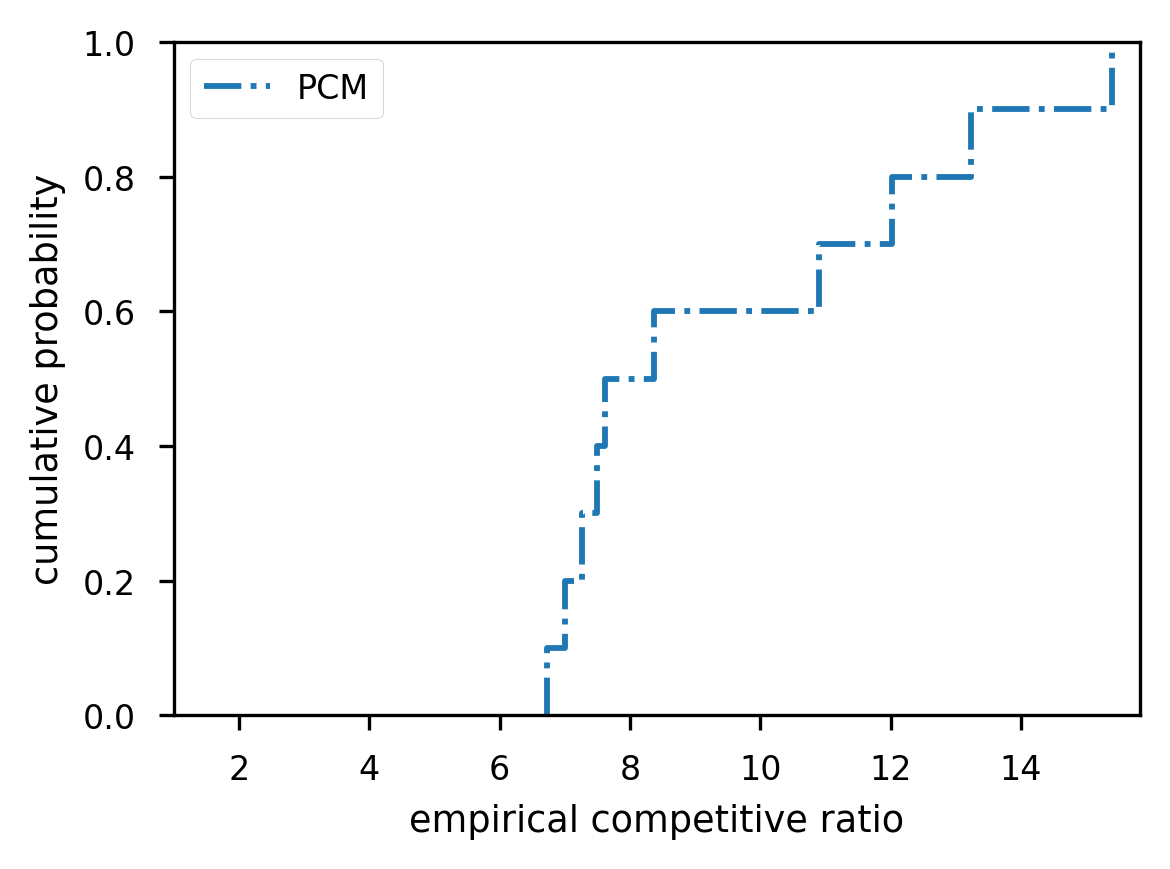

In [3]:
# robust experiment implementations for CASLB algorithms
# July 2024

import sys
import random
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import lambertw
import seaborn as sns
import pickle
import sys
from tqdm import tqdm
import warnings
import metric
import carbonTraces

warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True,precision=3)

import implementations as f
# import clip as c

import matplotlib.style as style
# style.use('tableau-colorblind10')
style.use('seaborn-v0_8-paper')

#################################### set up experiment parameters

# get the parameters from the command line

# how many regions to choose
# regions = int(sys.argv[1])

# gigabytes of data that need to be "transferred" (i.e. the diameter of the metric space)
setGB = 1 # float(sys.argv[1])

# scale factor for metric space
eastToWest = 221.0427046263345 # milliseconds
dist = eastToWest
minutesPerGB = 1.72118 
carbonPerGB = (minutesPerGB / 60) * 700
scale = setGB * (carbonPerGB / eastToWest)

# get tau from cmd args
tau = 1/scale #float(sys.argv[2]) / scale

# load in metric space
m = metric.MetricSpace(tau)
names = m.get_names()

# get the diameter
D = m.diameter() * scale

# get the distance matrix
simplex_names, c_simplex, simplex_distances = m.generate_simplex_distances()
dim = len(simplex_names)

# get the weight vector, the c vector, the name vector, and phi inverse
weights = m.get_weight_vector()
c_vector, name_vector = m.get_unit_c_vector()
phi_inverse = m.phi_inverse(names, name_vector, simplex_names)
phi = m.phi(names, name_vector, simplex_names)

# get the carbon trace
datetimes, carbon_vector = carbonTraces.get_numpy(m)
print(carbon_vector)

# get the simplex carbon trace
carbon_simplex = carbonTraces.get_simplex(simplex_names)

# job length (in hours)
job_length = 1

# scale the c_vector and c_simplex by the job length
c_vector = c_vector / job_length
c_simplex = c_simplex / job_length

# specify the number of instances to generate
epochs = 10

opts = []
pcms = []
lazys = []
agnostics = []
constThresholds = []
minimizers = []
cost_opts = []
cost_pcms = []
cost_lazys = []
cost_agnostics = []
cost_constThresholds = []
cost_minimizers = []

# eta = 1 / ( (U-D)/U + lambertw( ( (U-L-D+(2*tau)) * math.exp(D-U/U) )/U ) )

for _ in tqdm(range(epochs)):
    #################################### generate cost functions (a sequence)

    # randomly generate $T$ for each instance (the integer deadline)
    T = np.random.randint(6, 24)

    # randomly choose an index from datetimes, and make sure there are at least T days including/after that index
    index = np.random.randint(0, len(datetimes) - T)
    dtSequence = datetimes[index:index+T]

    # get the carbon traces for the sequence
    vectorSequence = carbon_vector[index:index+T, :]
    simplexSequence = carbon_simplex[index:index+T, :]

    # compute L and U based on cost functions
    costs = simplexSequence.flatten()
    Lc = np.min(costs[np.nonzero(costs)])
    Uc = np.max(costs)

    # pick a random name out of the subset of names
    start_state = random.choice(names)
    start_vector, start_simplex = m.get_start_state(start_state)
    
    #################################### solve for the optimal solution

    # try to solve for the optimal solution using scipy minimization
    sol, solCost = f.optimalSolution(simplexSequence, simplex_distances, scale, c_simplex, dim, start_simplex)
    print(simplex_names)
    # x_opt = sol.reshape((T, d))
    # print(sol)
    # print(x_opt)
    # print(solCost)
    # print(np.sum(x_opt))
    # obtain some advice based on the optimal solution
    # adv = sol.reshape((T, dim))

    #################################### get the online PCM solution

    print("L: ", Lc, "U: ", Uc, "D: ", D, "tau: ", tau*scale)

    pcm, pcmCost = f.PCM(simplexSequence, weights, scale, c_simplex, phi, dim, Lc, Uc/2, D, tau*scale, start_simplex)
    print(pcm @ c_simplex.T)
    print(pcm)
    print(pcmCost)
    print(start_simplex)
    print(simplexSequence)


    #################################### get the online comparison solutions

    # lazy, lazyCost = f.lazyAgnostic(cost_functions, weights, d)
    # agn, agnCost = f.agnostic(cost_functions, weights, d)

    # const, constCost = f.threshold(cost_functions, weights, d, L, U)

    # mini, miniCost = f.moveMinimizer(cost_functions, weights, d)

    #################################### get the online CLIP solution
    # epsilon = 0.1
    # clip0, clip0Cost = c.CLIP(cost_functions, weights, d, Lc, Uc, adv, epsilon)

    # epsilon = 2
    # clip2, clip2Cost = c.CLIP(cost_functions, weights, d, Lc, Uc, adv, epsilon)


    opts.append(sol)
    pcms.append(pcm)
    # lazys.append(lazy)
    # agnostics.append(agn)
    # constThresholds.append(const)
    # minimizers.append(mini)
    # clip0s.append(clip0)
    # clip2s.append(clip2)

    cost_opts.append(solCost)
    cost_pcms.append(pcmCost)
    # cost_lazys.append(lazyCost)
    # cost_agnostics.append(agnCost)
    # cost_constThresholds.append(constCost)
    # cost_minimizers.append(miniCost)
    # cost_clip0s.append(clip0Cost)
    # cost_clip2s.append(clip2Cost)


# compute competitive ratios
cost_opts = np.array(cost_opts)
cost_pcms = np.array(cost_pcms)
# cost_lazys = np.array(cost_lazys)
# cost_agnostics = np.array(cost_agnostics)
# cost_constThresholds = np.array(cost_constThresholds)
# cost_minimizers = np.array(cost_minimizers)
# cost_clip0s = np.array(cost_clip0s)
# cost_clip2s = np.array(cost_clip2s)

crPCM = cost_pcms/cost_opts
# crLazy = cost_lazys/cost_opts
# crAgnostic = cost_agnostics/cost_opts
# crConstThreshold = cost_constThresholds/cost_opts
# crMinimizer = cost_minimizers/cost_opts
# crClip0 = cost_clip0s/cost_opts
# crClip2 = cost_clip2s/cost_opts

# save the results (use a dictionary)
# results = {"opts": opts, "pcms": pcms, "lazys": lazys, "agnostics": agnostics, "constThresholds": constThresholds, "minimizers": minimizers,
#             "cost_opts": cost_opts, "cost_pcms": cost_pcms, "cost_lazys": cost_lazys, "cost_agnostics": cost_agnostics, "cost_constThresholds": cost_constThresholds, "cost_minimizers": cost_minimizers}
# with open(str(sys.argv[1]) + "/robust_results_r{}_dim{}_s{}_d{}.pickle".format((U/L), d, D, int(std)), "wb") as f:
#     pickle.dump(results, f)

# legend = ["ALG1", "lazy agnostic", "agnostic", "simple threshold", "move to minimizer"]
legend = ["PCM"]

# CDF plot for competitive ratio (across all experiments)
plt.figure(figsize=(4,3), dpi=300)
linestyles = ["-.", ":", "--", (0, (3, 1, 1, 1, 1, 1)), "-", '-.', ":"]

for list in zip([crPCM], linestyles):
    sns.ecdfplot(data = list[0], stat='proportion', linestyle = list[1])

plt.legend(legend)
plt.ylabel('cumulative probability')
plt.xlabel("empirical competitive ratio")
plt.tight_layout()
plt.xlim(left=1)
# plt.show()
plt.savefig("cdf_GB{}_l{}.png".format(setGB, job_length), facecolor='w', transparent=False, bbox_inches='tight')
# plt.clf()

# print mean and 95th percentile of each competitive ratio
print("Diameter: {}".format(D))
print("PCM: ", np.mean(crPCM), np.percentile(crPCM, 95))
# print("lazy agnostic: ", np.mean(crLazy), np.percentile(crLazy, 95))
# print("agnostic: ", np.mean(crAgnostic), np.percentile(crAgnostic, 95))
# print("simple threshold: ", np.mean(crConstThreshold), np.percentile(crConstThreshold, 95))
# print("move to minimizer: ", np.mean(crMinimizer), np.percentile(crMinimizer, 95))
# print("clip0: ", np.mean(crClip0), np.percentile(crClip0, 95))
# print("clip2: ", np.mean(crClip2), np.percentile(crClip2, 95))
# print("eta bound: ", eta)

In [9]:
print(Lc, Uc, D, tau*scale)

eta = 1 / ( (Uc-D)/Uc + lambertw( ( (D+Lc-Uc+(2*tau*scale)) * math.exp((D-Uc)/Uc) )/Uc ) ) 
print(eta.real)
print(eta.real * np.log(14))

24.47 749.6 77.47405970794168 1.0
5.886284502588876
15.534242260757878


In [5]:
# take the first hour of the carbon trace
carbon_trace = carbon_vector[0, :]
simplex_trace = carbon_simplex[0, :]

# iterate through a bunch of possible ON states
for state in names:
    # fix the start state to "us-east-1"
    start_state = "us-east-1"
    start_vector, start_simplex = m.get_start_state(start_state)

    # get an ON simplex vector for the current state
    on_simplex = np.zeros(len(simplex_names))
    on_simplex[simplex_names.index(state + " ON")] = 1

    # compute the pseudo-cost minimization between 0 and 1
    pcm = f.pcmMinimization(on_simplex, simplex_trace, eta.real, Uc, Lc, D, tau*scale, start_simplex, 0, weights, phi, scale, c_simplex)

    print("state: ", state, "pseudo-cost: ", pcm)


state:  us-east-1 pseudo-cost:  382.14 + Sum(abs([ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]) @ [  0.    620.43  620.43  620.43  310.215 310.215 310.215 310.215 310.215
 310.215  11.008 155.108 155.108 155.108 155.108  11.008 155.108 155.108
 155.108  11.008  11.008  11.008  77.554  77.554  11.008  11.008  11.008
  77.554  77.554  11.008  11.008  11.008  11.008  11.008  11.008], None, False) @ 0.09084413515152491 + -748.6 + -3200.838221626531 @ exp(0.16988645376556044) + --3200.838221626531 @ exp(0.0)
state:  us-west-1 pseudo-cost:  369.98 + Sum(abs([ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]) @ [  0.    620.43  620.43  620.43  310.215 310.215 310.215 310.215 310.215
 310.215  11.008 155.108 155.108 155.108 155.108  11.008 155.108 155.108
 155.108  11.008  11.008  11.008  77.554  77.554  11.

In [6]:
# for the first hour of the carbon trace, find the minimum non-zero index and print the corresponding name
print("simplex names: ", simplex_names)
print("simplex trace: ", simplex_trace)
index = np.argmin(simplex_trace[np.nonzero(simplex_trace)])
print("min non-zero index: ", index)
print("min non-zero name: ", simplex_names[index*2])


simplex names:  ['us-east-1 ON', 'us-east-1 OFF', 'us-west-1 ON', 'us-west-1 OFF', 'us-west-2 ON', 'us-west-2 OFF', 'af-south-1 ON', 'af-south-1 OFF', 'ap-south-2 ON', 'ap-south-2 OFF', 'ap-northeast-2 ON', 'ap-northeast-2 OFF', 'ap-southeast-2 ON', 'ap-southeast-2 OFF', 'ca-central-1 ON', 'ca-central-1 OFF', 'eu-central-1 ON', 'eu-central-1 OFF', 'eu-west-2 ON', 'eu-west-2 OFF', 'eu-west-3 ON', 'eu-west-3 OFF', 'eu-north-1 ON', 'eu-north-1 OFF', 'sa-east-1 ON', 'sa-east-1 OFF', 'il-central-1 ON', 'il-central-1 OFF']
simplex trace:  [382.14   0.   369.98   0.   325.75   0.   755.7    0.   741.99   0.
 477.98   0.   669.14   0.    28.23   0.   452.69   0.   221.52   0.
  65.6    0.    22.9    0.   101.48   0.   589.31   0.  ]
min non-zero index:  11
min non-zero name:  eu-north-1 ON


In [7]:
import cvxpy as cp

cost_func = simplex_trace
previous = start_simplex
accepted = 0
w = weights
c = c_simplex

In [8]:
print(eta.real)

5.886284502588876


In [24]:
x = cp.Variable(dim, pos=True)
constraints = [0 <= x, x <= 1, cp.sum(x) == 1]
prob = cp.Problem(cp.Minimize(f.pcmMinimization(x, cost_func, eta.real, Uc, Lc, D, tau*scale, previous, accepted, w, phi, scale, c)), constraints)
prob.solve(solver=cp.CLARABEL)
target = x.value
if np.sum(target) > 1.01:
    print("sum of target is greater than 1!  sum: {}".format(sum(target)))